# Projet Radiography Covid19

## 1 - Exploration des données

### 1.1 - Metadata et fichiers .png

In [25]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [26]:
cwd_dir = os.getcwd()
print(cwd_dir)

data_path = os.path.join("..", "data", "processed")
folder_content_list = os.listdir(
    data_path)
print(folder_content_list)


c:\Users\Florent\Documents\data_science\MAR24_BDS_Radios_Pulmonaire\notebooks
['.gitkeep', 'average_images', 'Lung Segmentation Data']


In [27]:
# parametres
data_path = os.path.join("..", "data", "processed")
average_images_path = os.path.join(data_path, "average_images")
covid_path = os.path.join(data_path, "Lung Segmentation Data", "COVID-19")
noncovid_path = os.path.join(data_path, "Lung Segmentation Data", "Non-COVID")
normal_path = os.path.join(data_path, "Lung Segmentation Data", "Normal")

dict_data_path = {
    'COVID' : covid_path,
    'Non-COVID' : noncovid_path,
    'Normal' : normal_path,
}

#### Description du contenu des dossiers **images** et **masks**

In [28]:
# Nombre de fichiers et formats par dossier 

rows_data = []

for key, path in dict_data_path.items():

    for folder in ["images", "lung masks"]:
        folder_path  = os.path.join(path, folder)
        files = os.listdir(folder_path) 
    
        nb_files = len(files)
        formats = [file.split(".")[-1] for file in files]
        nb_format = len(set(formats))
        distinct_formats = list(set(formats))
        ex_file_name = files[0]

        rows_data.append({
            "data": key, 
            "dossier": folder, 
            "Nb fichiers": nb_files, 
            "Nb de formats differents": nb_format, 
            "Formats présents": distinct_formats,
            "exemple nom fichier": ex_file_name
        })

df_descr_data = pd.DataFrame(rows_data)

print("shape df_descr_data :", df_descr_data.shape)
df_descr_data.head(8)

shape df_descr_data : (6, 6)


,data,dossier,Nb fichiers,Nb de formats differents,Formats présents,exemple nom fichier
0,COVID,images,11956,1,[png],covid_1.png
1,COVID,lung masks,11956,1,[png],covid_1.png
2,Non-COVID,images,11263,1,[png],non_COVID (1).png
3,Non-COVID,lung masks,11263,1,[png],non_COVID (1).png
4,Normal,images,10701,1,[png],Normal (1).png
5,Normal,lung masks,10701,1,[png],Normal (1).png


#### Cohérence entre **images** et **masks**

In [29]:
# Tous les noms de fichier du dossier images sont-ils bien retrouvés dans le dossier lung masks ?

rows_images_masks = []

for key, path in dict_data_path.items():

    images_path = os.path.join(path, "images")
    masks_path = os.path.join(path, "lung masks")
    
    images_files = set(os.listdir(images_path))
    masks_files = set(os.listdir(masks_path))

    images_not_in_masks = images_files - masks_files
    masks_not_in_images = masks_files - images_files

    nb_images_not_in_masks = len(images_not_in_masks)
    nb_masks_not_in_images = len(masks_not_in_images)

    if nb_images_not_in_masks not in locals():
        nb_images_not_in_masks = 0

    if nb_masks_not_in_images not in locals():
        nb_masks_not_in_images = 0

    rows_images_masks.append({
        "data": key, 
        "Nb fichiers dans images": len(images_files),
        "Nb fichiers dans lung masks": len(masks_files),
        "Nb images non retrouvés dans lung masks": nb_images_not_in_masks, 
        "Nb lung masks non retrouvés dans images": nb_masks_not_in_images
        })

df_descr_images_masks = pd.DataFrame(rows_images_masks)


print("shape df_descr_images_masks :", df_descr_images_masks.shape)
df_descr_images_masks.head(3)


shape df_descr_images_masks : (3, 5)


,data,Nb fichiers dans images,Nb fichiers dans lung masks,Nb images non retrouvés dans lung masks,Nb lung masks non retrouvés dans images
0,COVID,11956,11956,0,0
1,Non-COVID,11263,11263,0,0
2,Normal,10701,10701,0,0


#### Cohérence avec les **effectifs** sur le fichier **COVID-QU-Ex dataset.txt**

Effectifs par source de donnée sur le .txt :  
11,956 COVID-19  
11,263 Non-COVID infections (Viral or Bacterial Pneumonia)  
10,701 Normal  

#### **Conclusion** sur les .png

- 3 jeux de données : COVID, Non-COVID, Normal.

- Chaque jeu de données contient dossiers contenant des .pn,g : "images" et "lung masks".  

- Cohérence parfaite images et lung masks : chaque id est retrouvé dans les 3 sources.  

- On retrouve bien les effectifs annoncés dans le fichier .trxt qui accompagne les données.


### 1.2 - Description des .png

- Nombre de canaux  = nombre de couches de couleurs dans l'image, si niveau de gris : 1 seul canal, en couleur : 3 (RVB)
- Images moyennes : calculer une image moyenne en combinant plusieurs images pour obtenir moyenne de l'ensemble des données : pour avoir une idée de l'apparence des images par jeu de données ?
- Intensité de pixels : distribution (quartiles, std, mean...) pour avoir des infos sur la luminosité et le contraste des images

+ ACP ? 

#### Indicateurs et calcul de l'image moyenne/dataset


In [31]:
# Description des images
# + calcul d'une image moyenne

png_data = []

for key, path in dict_data_path.items():
    for folder in ["images", "lung masks"]:
        folder_path  = os.path.join(path, folder)

        png_list = []

        for png_file in os.listdir(folder_path):

            png_path = os.path.join(folder_path, png_file)

            # chargement de l'image avec OpenCV en niveau de gris
            png = cv2.imread(png_path, cv2.IMREAD_GRAYSCALE) 

            # caracteristiques de l'image
            height, width = png.shape
            channels = 1  # Niveaux de gris
            mean_intensity = np.mean(png)
            std_intensity = np.std(png)
            min_intensity = np.min(png)
            max_intensity = np.max(png)

            png_data.append({
                "data": key, 
                "dossier": folder, 
                "Png name": png_file,
                "Hauteur": height,
                "Largeur": width,
                "Canaux": channels,
                "Intensité moyenne": mean_intensity,
                "Ecart type Intensité": std_intensity,
                "Min Intensité": min_intensity,
                "Max Intensité": max_intensity
            })
        
            # enregistrement de l'image dans la liste
            png_list.append(png)

        # calcul de l'image moyenne
        average_image = np.mean(png_list, axis=0).astype(np.uint8)
        # export de l'image moyenne dans un fichier
        cv2.imwrite(os.path.join(average_images_path, f"average_image_{key}_{folder}.png"), average_image)

df_descr_png = pd.DataFrame(png_data)


print("shape df_descr_png :", df_descr_png.shape)
df_descr_png.head(16)


shape df_descr_png : (67840, 10)


,data,dossier,Png name,Hauteur,Largeur,Canaux,Intensité moyenne,Ecart type Intensité,Min Intensité,Max Intensité
0,COVID,images,covid_1.png,256,256,1,145.647568,54.561958,0,255
1,COVID,images,covid_10.png,256,256,1,185.029297,45.531100,2,250
2,COVID,images,covid_100.png,256,256,1,98.156174,47.601039,0,235
3,COVID,images,covid_1000.png,256,256,1,156.994400,34.814890,27,239
4,COVID,images,covid_1001.png,256,256,1,98.653915,65.537775,0,252
5,COVID,images,covid_1002.png,256,256,1,153.679977,53.205535,0,255
6,COVID,images,covid_1003.png,256,256,1,57.303009,18.879878,0,224
7,COVID,images,covid_1004.png,256,256,1,130.510590,76.741802,0,236
8,COVID,images,covid_1005.png,256,256,1,147.750443,41.741095,0,212
9,COVID,images,covid_1007.png,256,256,1,158.417603,48.918579,2,251


#### Dimensions des images

In [32]:
# Dimension des images 

print(df_descr_png.groupby(['data', 'dossier'])['Hauteur'].value_counts())
print(df_descr_png.groupby(['data', 'dossier'])['Largeur'].value_counts())

print(df_descr_png.groupby(['dossier'])['Hauteur'].value_counts())
print(df_descr_png.groupby(['dossier'])['Largeur'].value_counts())

data       dossier     Hauteur
COVID      images      256        11956
           lung masks  256        11956
Non-COVID  images      256        11263
           lung masks  256        11263
Normal     images      256        10701
           lung masks  256        10701
Name: count, dtype: int64
data       dossier     Largeur
COVID      images      256        11956
           lung masks  256        11956
Non-COVID  images      256        11263
           lung masks  256        11263
Normal     images      256        10701
           lung masks  256        10701
Name: count, dtype: int64
dossier     Hauteur
images      256        33920
lung masks  256        33920
Name: count, dtype: int64
dossier     Largeur
images      256        33920
lung masks  256        33920
Name: count, dtype: int64


Dimensions 256x256 pour toutes les images et tous les masks.

#### Distribution de l'intensité moyenne des pixels

Intensité moyenne pour chaque fichier .png, par jeu de données (COVID, NORMAL...) et par dossier (images, masks)

On sépare les descriptions sur les fichiers 'images' des fichiers 'masks'.

##### images

In [33]:
def display_distrib_int_pixels(df, titre):
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    axes = axes.flatten()

    for i, (data, group) in enumerate(df.groupby('data')):
        q1 = group['Intensité moyenne'].quantile(0.25)
        median = group['Intensité moyenne'].median()
        q3 = group['Intensité moyenne'].quantile(0.75)
        moy = group['Intensité moyenne'].mean()
        sd = group['Intensité moyenne'].std()

        ax = axes[i]  # Select the current subplot

        sns.histplot(data=group, x='Intensité moyenne', kde=True, ax=ax)

        ax.set_title(f'{data}')
        ax.set_xlabel('Intensité moyenne')
        ax.set_ylabel('Frequency')

        # info distrib : 
        ax.text(0.95, 0.95, f'Q1: {q1:.2f}', ha='right', va='top', transform=ax.transAxes)
        ax.text(0.95, 0.85, f'Median: {median:.2f}', ha='right', va='top', transform=ax.transAxes)
        ax.text(0.95, 0.75, f'Q3: {q3:.2f}', ha='right', va='top', transform=ax.transAxes)
        ax.text(0.95, 0.65, f'Moyenne: {moy:.2f}', ha='right', va='top', transform=ax.transAxes)
        ax.text(0.95, 0.55, f'Std: {sd:.2f}', ha='right', va='top', transform=ax.transAxes)

    # plt.tight_layout() # Adjust layout to prevent overlap of subplot titles
    fig.suptitle(titre, fontsize=16)
    plt.subplots_adjust(top=0.9, bottom=0.1, left=0.1, right=0.9, hspace=0.5, wspace=0.5)

    plt.show()

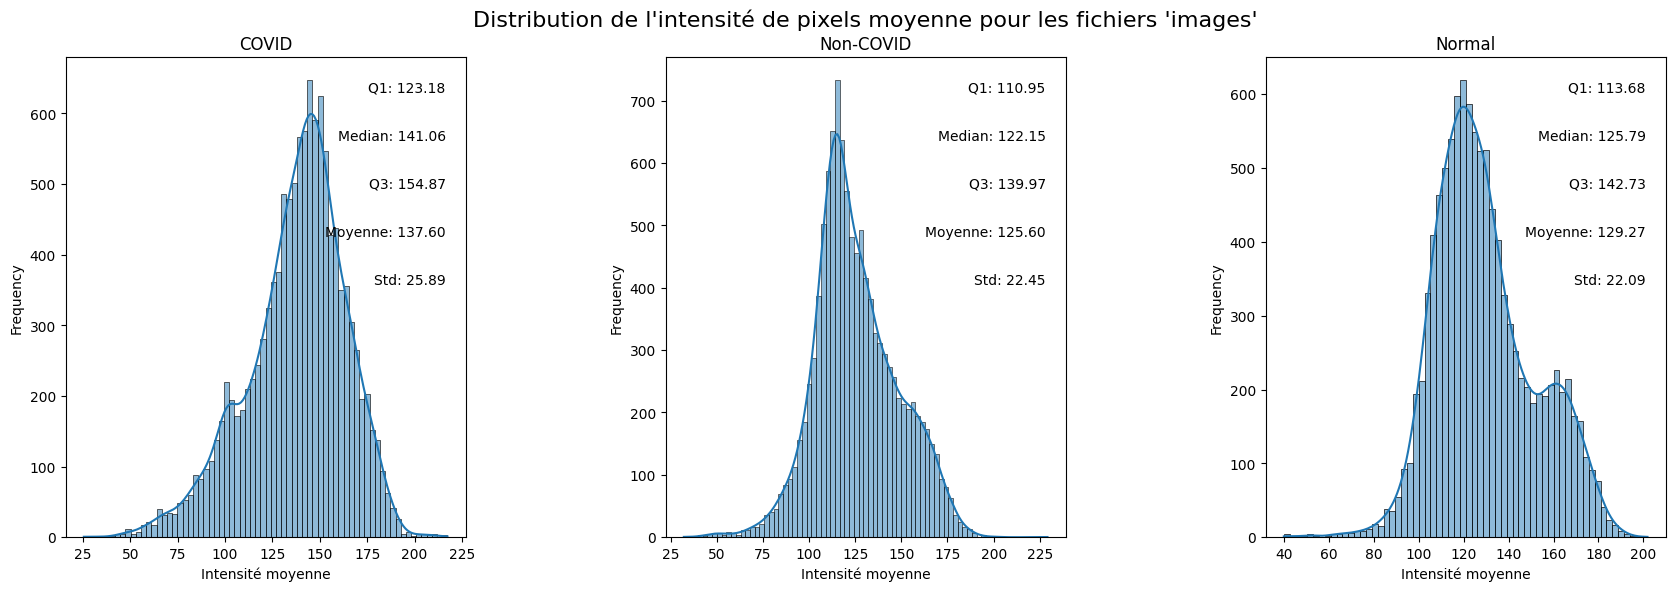

In [34]:
# Pour les images

df_images = df_descr_png.loc[df_descr_png.dossier == "images"]

display_distrib_int_pixels(df_images, "Distribution de l'intensité de pixels moyenne pour les fichiers 'images'")

##### masks

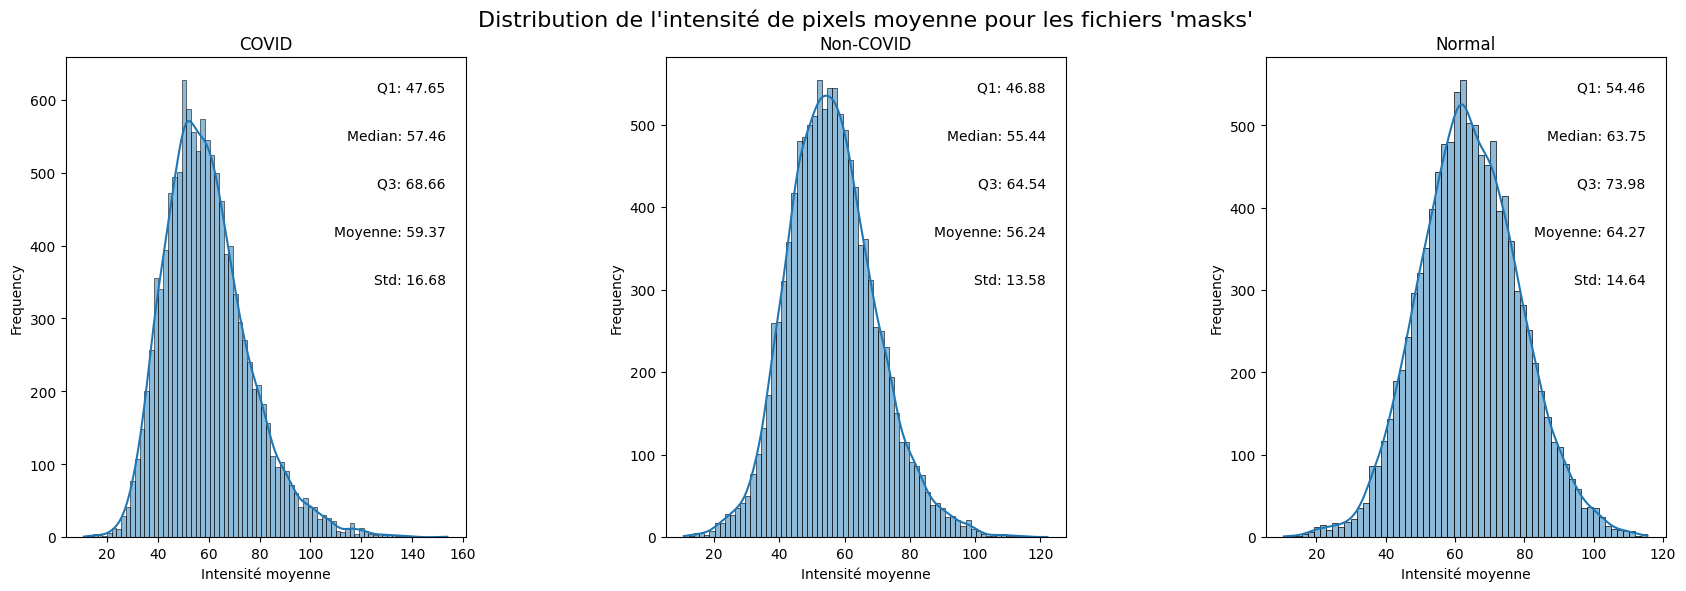

In [35]:
# Pour les masks

df_masks = df_descr_png.loc[df_descr_png.dossier == "lung masks"]

display_distrib_int_pixels(df_masks, "Distribution de l'intensité de pixels moyenne pour les fichiers 'masks'")

#### Images moyennes

##### images

In [36]:
def display_images_moyennes(png_dict, titre):
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    # Flatten the axes array
    axes = axes.flatten()

    # Load and display each image in a subplot
    for i, (image_file, title) in enumerate(png_dict.items()):
        image_path = os.path.join(average_images_path, image_file)

        # Load the image
        image = plt.imread(image_path)

        # Display the image as grayscale
        axes[i].imshow(image, cmap='gray')
        
        axes[i].set_title(title)
        axes[i].axis('off')

    # Adjust layout and display the figure
    # plt.tight_layout()
    fig.suptitle(titre, fontsize=16)
    plt.subplots_adjust(top=0.9, bottom=0.1, left=0.1, right=0.9, hspace=0.5, wspace=0.5)
    
    plt.show()

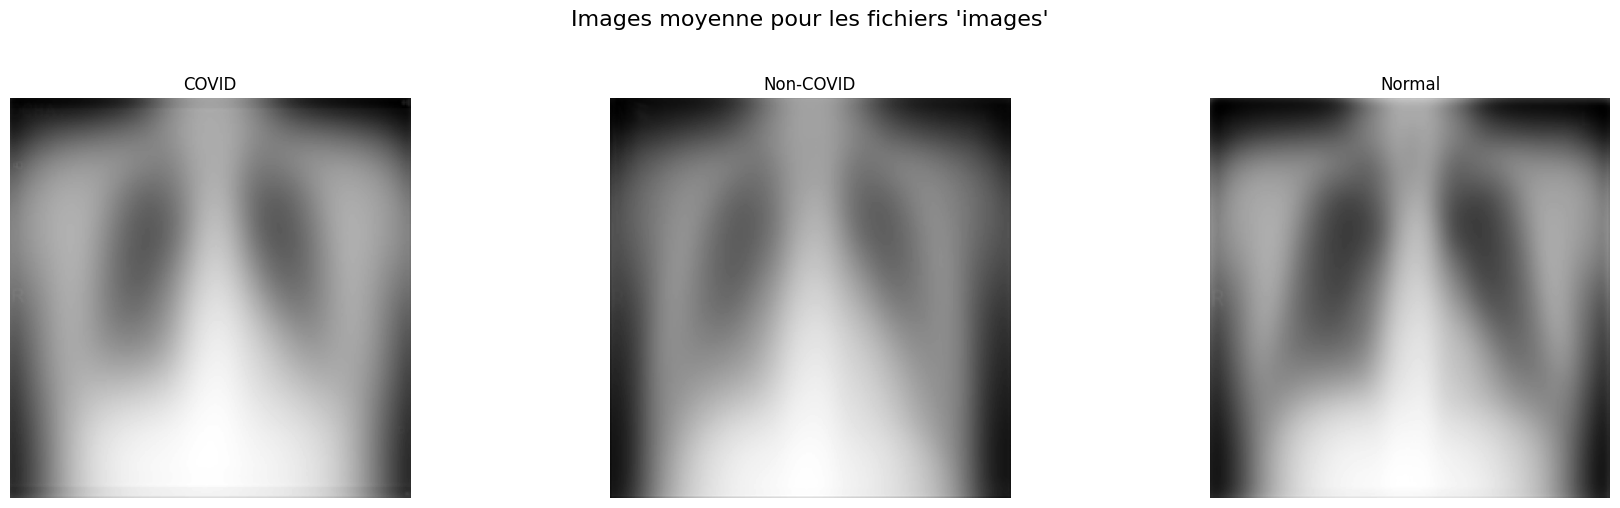

In [37]:
# images moyennes pour images

images_dict = {
    "average_image_COVID_images.png": "COVID",
    "average_image_Non-Covid_images.png": "Non-COVID",
    "average_image_Normal_images.png": "Normal",
}

display_images_moyennes(images_dict, "Images moyenne pour les fichiers 'images'")



##### masks

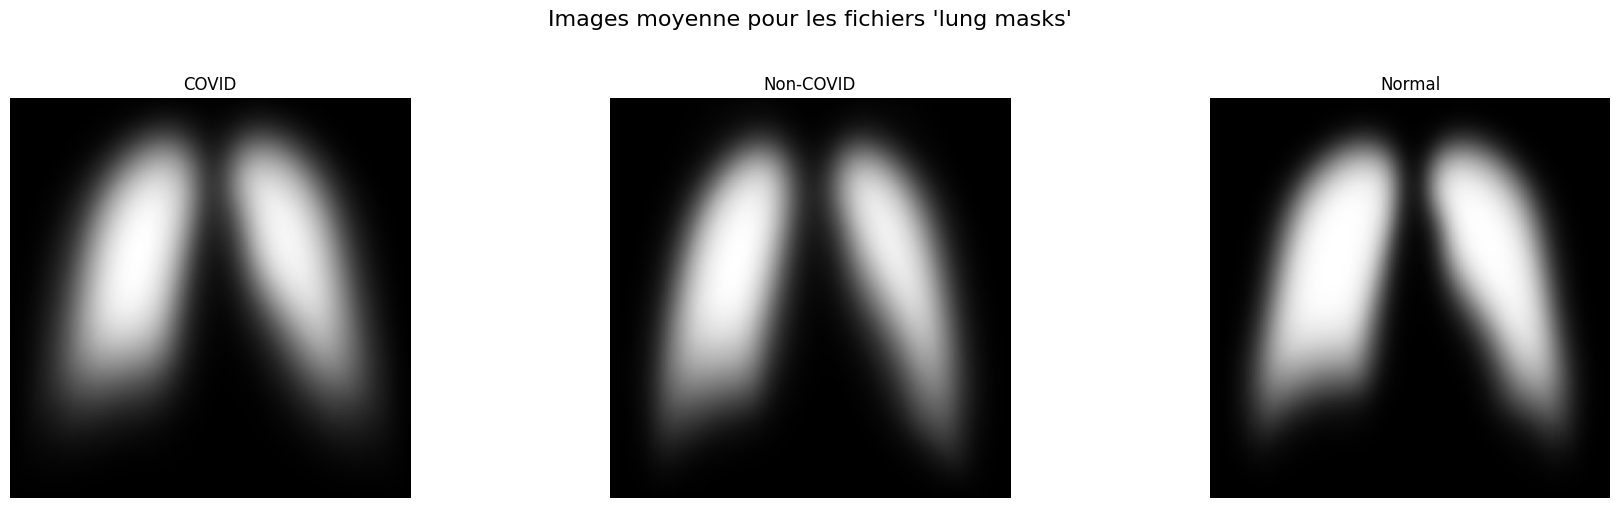

In [41]:
# images moyennes pour masks

masks_dict = {
    "average_image_COVID_lung masks.png": "COVID",
    "average_image_Non-Covid_lung masks.png": "Non-COVID",
    "average_image_Normal_lung masks.png": "Normal",
}

display_images_moyennes(masks_dict, "Images moyenne pour les fichiers 'lung masks'")